The purpose of this notebook is to create the outline for a function which processes all of the training data and extracts useful information.


In [19]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
sys.path.insert(1, str(Path().resolve().parent) + r'\Preprocessing')
from chart_functions import chart2tensor, get_configuration
import pickle
import numpy as np

unprocessed_data_path = Path(r'X:\Training Data\Unprocessed')
processed_data_path = Path(r'X:\Training Data\Processed')

Things to measure from the data
- File list
    - Audio files present (distribution of .ogg files)
    - Which track pack the song is from
- Song data
    - Song length (given in milliseconds)
    - Genre
    - Delay
- Note information
    - How many of each type of note there is
- Total size of training data
    - Measured by song file size + chart file size

In [2]:
next(os.walk(unprocessed_data_path))[1]

['Anti Hero', 'Community Track Pack 6', 'Focal Point']

In [3]:
ogg_list = {}     # How many audio files of type .ogg per folder
mp3_list = {}     # How many audio files of type .mp3 per folder
wav_list = {}     # How many audio files of type .wav per folder
track_pack = {}   # Distribution of songs per track pack
lengths = []      # Song lengths in seconds
sizes = {}         # Size of training data per track pack
genres = {}       # Distribution of song genres
delays = {}       # Distribution of delay

for dirName, subdirList, fileList in os.walk(unprocessed_data_path):  # Walk through training data directory
    if not fileList:  # If file list is empty
        continue
    
    # Get track pack
    track_pack_ = str(Path(dirName).parent).split('\\')[3]
    # print('Track Pack: %s' % str(Path(dirName).parent).split('\\')[3])
    if track_pack_ not in track_pack.keys():
        track_pack[track_pack_] = 1
    else:
        track_pack[track_pack_] += 1

    # Get audio file list
    num_ogg_files = 0
    num_mp3_files = 0
    num_wav_files = 0
    mp3 = False         # Boolean to determine if songs are in mp3 format
    wav = False
    for track in fileList:
        if track.endswith('.ogg'):
            num_ogg_files += 1
        if track.endswith('.mp3'):
            num_mp3_files += 1
        if track.endswith('.wav'):
            num_wav_files += 1
    if num_ogg_files > 0:
        if num_ogg_files not in ogg_list.keys():
            ogg_list[num_ogg_files] = 1
        else:
            ogg_list[num_ogg_files] += 1
    if num_mp3_files > 0:
        mp3 = True
        if num_mp3_files not in mp3_list.keys():
            mp3_list[num_mp3_files] = 1
        else:
            mp3_list[num_mp3_files] += 1
    if num_wav_files > 0:
        wav = True
        if num_wav_files not in wav_list.keys():
            wav_list[num_wav_files] = 1
        else:
            wav_list[num_wav_files] += 1
    
    # Get song data
    configuration = get_configuration(dirName)
    # Get lengths
    try:    # Sometimes there's an extra space at the end of the key of configuration
        lengths.append(configuration['song_length '] / 1000)  # ms -> s
    except:
        if 'song_length' in configuration.keys():
            lengths.append(configuration['song_length'] / 1000)  # ms -> s
    # Get genres
    try:
        if 'genre ' in configuration.keys():
            if configuration['genre '] not in genres.keys():
                genres[configuration['genre ']] = 1
            else:
                genres[configuration['genre ']] += 1
    except:
        if 'genre' in configuration.keys():
            if configuration['genre'] not in genres.keys():
                genres[configuration['genre']] = 1
            else:
                genres[configuration['genre']] += 1
    # Get delays
    try:
        if 'delay ' in configuration.keys():
            if configuration['delay '] not in delays.keys():
                delays[configuration['delay ']] = 1
            else:
                delays[configuration['delay ']] += 1
    except:
        if 'delay' in configuration.keys():
            if configuration['delay'] not in delays.keys():
                delays[configuration['delay']] = 1
            else:
                delays[configuration['delay']] += 1

    # Get size of data
    if num_ogg_files > 1 or num_mp3_files > 1:
        continue # Skip files with separated sources
    if mp3:
        audio_file_name = [i for i in fileList if i.endswith('.mp3')][0]
        audio_file_path = Path(dirName).joinpath(audio_file_name)
        chart_file_path = Path(dirName).joinpath('notes.chart')
        size = (audio_file_path.stat().st_size + chart_file_path.stat().st_size) / 1e9
    elif wav:
        audio_file_name = [i for i in fileList if i.endswith('.wav')][0]
        audio_file_path = Path(dirName).joinpath(audio_file_name)
        chart_file_path = Path(dirName).joinpath('notes.chart')
        size = (audio_file_path.stat().st_size + chart_file_path.stat().st_size) / 1e9
    else:
        audio_file_name = [i for i in fileList if i.endswith('.ogg')][0]
        audio_file_path = Path(dirName).joinpath(audio_file_name)
        chart_file_path = Path(dirName).joinpath('notes.chart')
        size = (audio_file_path.stat().st_size + chart_file_path.stat().st_size) / 1e9
    if track_pack_ not in sizes.keys():
        sizes[track_pack_] = size
    else:
        sizes[track_pack_] += size

print('Track pack distribution: ', track_pack)
print('.ogg files: ', ogg_list)
print('.mp3 files: ', mp3_list)
print('.wav files: ', wav_list)
print('Delays: ', delays)
print('Sizes: ', sizes)


Track pack distribution:  {'Anti Hero': 171, 'Community Track Pack 6': 59, 'Focal Point': 82}
.ogg files:  {1: 268, 2: 2, 3: 5, 4: 4, 5: 1}
.mp3 files:  {1: 29, 2: 1}
.wav files:  {1: 5}
Delays:  {0: 32, 2000: 1}
Sizes:  {'Anti Hero': 1.5027012299999993, 'Community Track Pack 6': 0.6517439810000001, 'Focal Point': 0.8020256750000004}


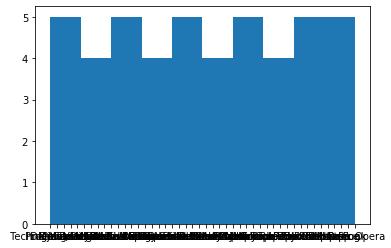

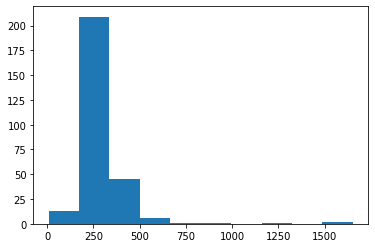

In [4]:
# Plotting
plt.hist(genres);
plt.figure()
plt.hist(lengths);

The following section will analyze the note composition of each song.

- For each song
    - Get the notes
    - Create a folder in "processed" if one doesn't exist already
    - Into that folder, put
        - Dictionary of note distribution
    - Record...
        - Total note distribution per track pack
            - Held
            - Released
            - Notes
            - Modifier

In [5]:
def check_multiple_audio_files(fileList):
    # Get audio file list
    num_files = 0
    multiple_files = False
    mp3 = False         # Boolean to determine if songs are in mp3 format
    wav = False
    for track in fileList:
        if track.endswith('.ogg'):
            num_files += 1
        if track.endswith('.mp3'):
            num_files += 1
        if track.endswith('.wav'):
            num_files += 1
    if num_files > 1:
        multiple_files = True
    return multiple_files

In [17]:
# load dictionaries
dict_path = Path.cwd().parent / 'Resources'

with open(dict_path / 'combo_dict.pkl', 'rb') as handle:
    combo_dict = pickle.load(handle)
with open(dict_path / 'hold_dict.pkl', 'rb') as handle:
    hold_dict = pickle.load(handle)
with open(dict_path / 'modifier_dict.pkl', 'rb') as handle:
    modifier_dict = pickle.load(handle)
with open(dict_path / 'note_dict.pkl', 'rb') as handle:
    note_dict = pickle.load(handle)

In [33]:
num_zero = 0        # To measure sparsity of notes
num_nonzero = 0


for dirName, subdirList, fileList in os.walk(unprocessed_data_path):  # Walk through training data directory
    if not fileList:  # If file list is empty
        continue
    track_pack_ = str(Path(dirName).parent).split('\\')[3]
    song_ = str(Path(dirName)).split('\\')[4]
    processed_song_path = processed_data_path / track_pack_ / song_
    unprocessed_song_path = unprocessed_data_path / track_pack_ / song_

    # Skip creating the directory if there is more than one audio file
    if check_multiple_audio_files(fileList):
        continue

    if not processed_song_path.exists():
        os.mkdir(processed_song_path)
    
    # Create note tensor for song
    # print('\nGetting notes for %s' % song_)
    note_tensor = np.array(chart2tensor(unprocessed_song_path / 'notes.chart', print_release_notes = False)).astype(int)

    # Analyze for sparsity (number of zeros / total notes)
    num_zero += np.count_nonzero(note_tensor == 0)
    num_nonzero += (len(note_tensor) - np.count_nonzero(note_tensor == 0))

    # dense_notes is the note tensor with all the zeros removed
    dense_notes = note_tensor[note_tensor != 0]

    # Parse through dense_notes, extracting information
    modifier = []
    held = []
    for x in dense_notes:
        modifier.append(modifier_dict[x])
        held.append(hold_dict[x])
    break

print('num_nonzero = ', num_nonzero)
print('num_zero = ', num_zero)
print('Sparsity = %4.3f' % (num_nonzero / (num_nonzero + num_zero)))



num_nonzero =  1939
num_zero =  134765
Sparsity = 0.014


Text(0.5, 1.0, "Distribution of 'Held' vs 'Released'")

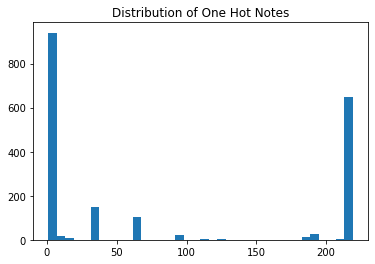

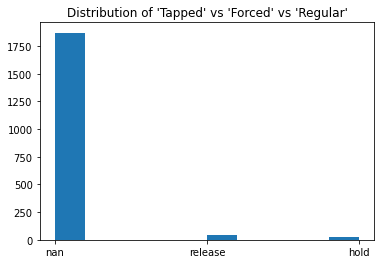

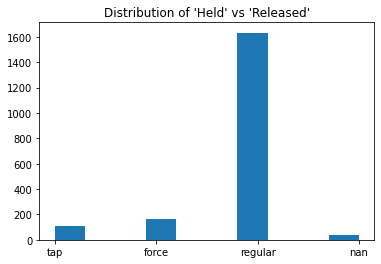

In [35]:
plt.hist(dense_notes, bins = len(np.unique(dense_notes)));
plt.title('Distribution of One Hot Notes')

plt.figure()
plt.hist(held)
plt.title('Distribution of \'Tapped\' vs \'Forced\' vs \'Regular\'')

plt.figure()
plt.hist(modifier)
plt.title('Distribution of \'Held\' vs \'Released\'')